In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import dijet
import random
from IPython.display import display, Math

# setup plotting
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 16  
plt.rcParams["xtick.labelsize"] = 14  
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 18  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
%config InlineBackend.figure_format = 'retina'

In [3]:

roots = 95
pT_values = np.linspace(0.5, 10, 20)

xis = [0.0, 0.3, 0.6]
djs = {xi: dijet.DIJET(fit_type='pp', constrained_moments=True, IR_reg=['gauss', xi]) for xi in xis}

space = {
    'y' : [0.05, 0.95],
    'z' : [0.2, 0.5],
    'Q2': [16, 100],
    't' : 0.1,
    'phi_Dp': [0, 2*np.pi],
    'phi_kp': [0, 2*np.pi]
}
r0s = [2.0, 1.0, 0.5]

npoints = 8

corr = {}
corr['space'] = space
corr['pT values'] = pT_values
corr['roots'] = roots

for ixi, xi in enumerate(xis):
    corr[xi] = {}
    for r0 in r0s:
        print('xi, r0', xi, r0)
        
        corr[xi][r0] = {}

        denom = djs[xi].get_integrated_xsec(pT_values, roots**2, space, points=npoints, kind='den', r0=r0)
        corr[xi][r0]['<1>'] = djs[xi].get_integrated_xsec(pT_values, roots**2, space, weight='1', points=npoints, kind='num', r0=r0)/denom
        corr[xi][r0]['<cos(phi_Dp)>'] = djs[xi].get_integrated_xsec(pT_values, roots**2, space, weight='cos(phi_Dp)', points=npoints, kind='num', r0=r0)/denom
        corr[xi][r0]['<cos(phi_Dp)cos(phi_kp)>'] = djs[xi].get_integrated_xsec(pT_values, roots**2, space, weight='cos(phi_Dp)cos(phi_kp)', points=npoints, kind='num', r0=r0)/denom
        corr[xi][r0]['<sin(phi_Dp)sin(phi_kp)>'] = djs[xi].get_integrated_xsec(pT_values, roots**2, space, weight='sin(phi_Dp)sin(phi_kp)', points=npoints, kind='num', r0=r0)/denom
        corr[xi][r0]['denom'] = denom
        
        np.save(f'data/lowQ2_corr_oam3_range10.npy', corr, allow_pickle=True)


--> !!! Using constrained moment parameters!
--> loaded unpol. amp. data from /dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
--> loaded pol. amp. data from /dipoles/d05-rc/
--> loaded params from /dipoles/replica_params_pp.csv
--> loaded random moment params from /dipoles/moment_params_pp_oam3_range10.csv
--> loaded replica 1
--> !!! Using constrained moment parameters!
--> loaded unpol. amp. data from /dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
--> loaded pol. amp. data from /dipoles/d05-rc/
--> loaded params from /dipoles/replica_params_pp.csv
--> loaded random moment params from /dipoles/moment_params_pp_oam3_range10.csv
--> loaded replica 1
--> !!! Using constrained moment parameters!
--> loaded unpol. amp. data from /dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
--> loaded pol. amp. data from /dipoles/d05-rc/
--> loaded params from /dipoles/replica_params_pp.csv
--> loaded random moment params from /dipoles/moment_params_pp_oam3_range10.csv
--> loaded replica 1
xi, r0 0.0 2.0
xi, r0 0.0

In [2]:
# calculate bands for correlations

data = np.load('data/lowQ2_corr_oam3_range10.npy', allow_pickle=True).item()

confid = 65

xis = [key for key in data if key not in ['space', 'pT values', 'roots']]
r0s = [key for key in data[xis[0]]]

lumi = 100
error = {}

for xi in xis:
    error[xi] = {}
    for r0 in r0s:
        # data[xi][r0]['<cos(phi_Dp + phi_kp)>'] = data[xi][r0]['<cos(phi_Dp)cos(phi_kp)>'] - data[xi][r0]['<sin(phi_Dp)sin(phi_kp)>']
        # data[xi][r0]['<cos(phi_Dp - phi_kp)>'] = data[xi][r0]['<cos(phi_Dp)cos(phi_kp)>'] + data[xi][r0]['<sin(phi_Dp)sin(phi_kp)>']

        error[xi][r0] = {}
        error[xi][r0]['all'] = np.sqrt(1/(2*lumi*np.array(data[xi][r0]['denom'])))
        error[xi][r0]['tt'] = np.sqrt(2.0/(2*lumi*np.array(data[xi][r0]['denom'])))
        error[xi][r0]['lt'] = np.sqrt(4.0/(2*lumi*np.array(data[xi][r0]['denom'])))


# get kinematics + make labels
space = data['space']
pT_values = data['pT values']
roots = data['roots']

space_labels = {
    'y' : r'y',
    'z' : r'z',
    'Q2': r'Q^2',
    't' : r't',
    'phi_Dp': r'\phi_{\Delta p}',
    'phi_kp': r'\phi_{k p}'
}

var_labels = [r'p_{\perp}']
for key in space:
    if isinstance(space[key], list): continue
    var_labels.append(space_labels[key])

num_label = '{}' if len(var_labels)==1 else fr'{len(var_labels)}'
den_label = ''.join(['d' + v for v in var_labels])

info_text = fr'$\sqrt{{s}} = {roots}\,\, \mathrm{{GeV}}$' + '\n'

for var in space:
    if isinstance(space[var], list): 
        low = space[var][0]
        high = space[var][1]
        # if var == 'Q2':
        #     info_text += fr'$Q^2 \, \in \,[{round(low,1)}, \, {round(high,1)}]\, \mathrm{{GeV^2}}$' + '\n'
        if var == 'y':
            info_text += fr'$y \, \in \, [{round(low,3)}, \, {round(high,3)}]$' + '\n'
        elif var == 'z':
            info_text += fr'$z \, \in \, [{round(low,2)}, \, {round(high,2)}]$' + '\n'
        elif var == 't':
            info_text += fr'$t \, \in \,  [{round(low,2)}, \, {round(high,2)}]\, \mathrm{{GeV}}^2$'
    else:
        value = space[var]
        if var == 'Q2':
            info_text += fr'$Q^2 \, = \,{value}\, \mathrm{{GeV^2}}$' + '\n'
        elif var == 'y':
            info_text += fr'$y \, = \, {value}$' + '\n'
        elif var == 'z':
            info_text += fr'$z \, = \, {value}$' + '\n'
        elif var == 't':
            info_text += fr'$t \, = \,  {value}\, \mathrm{{GeV}}^2$'


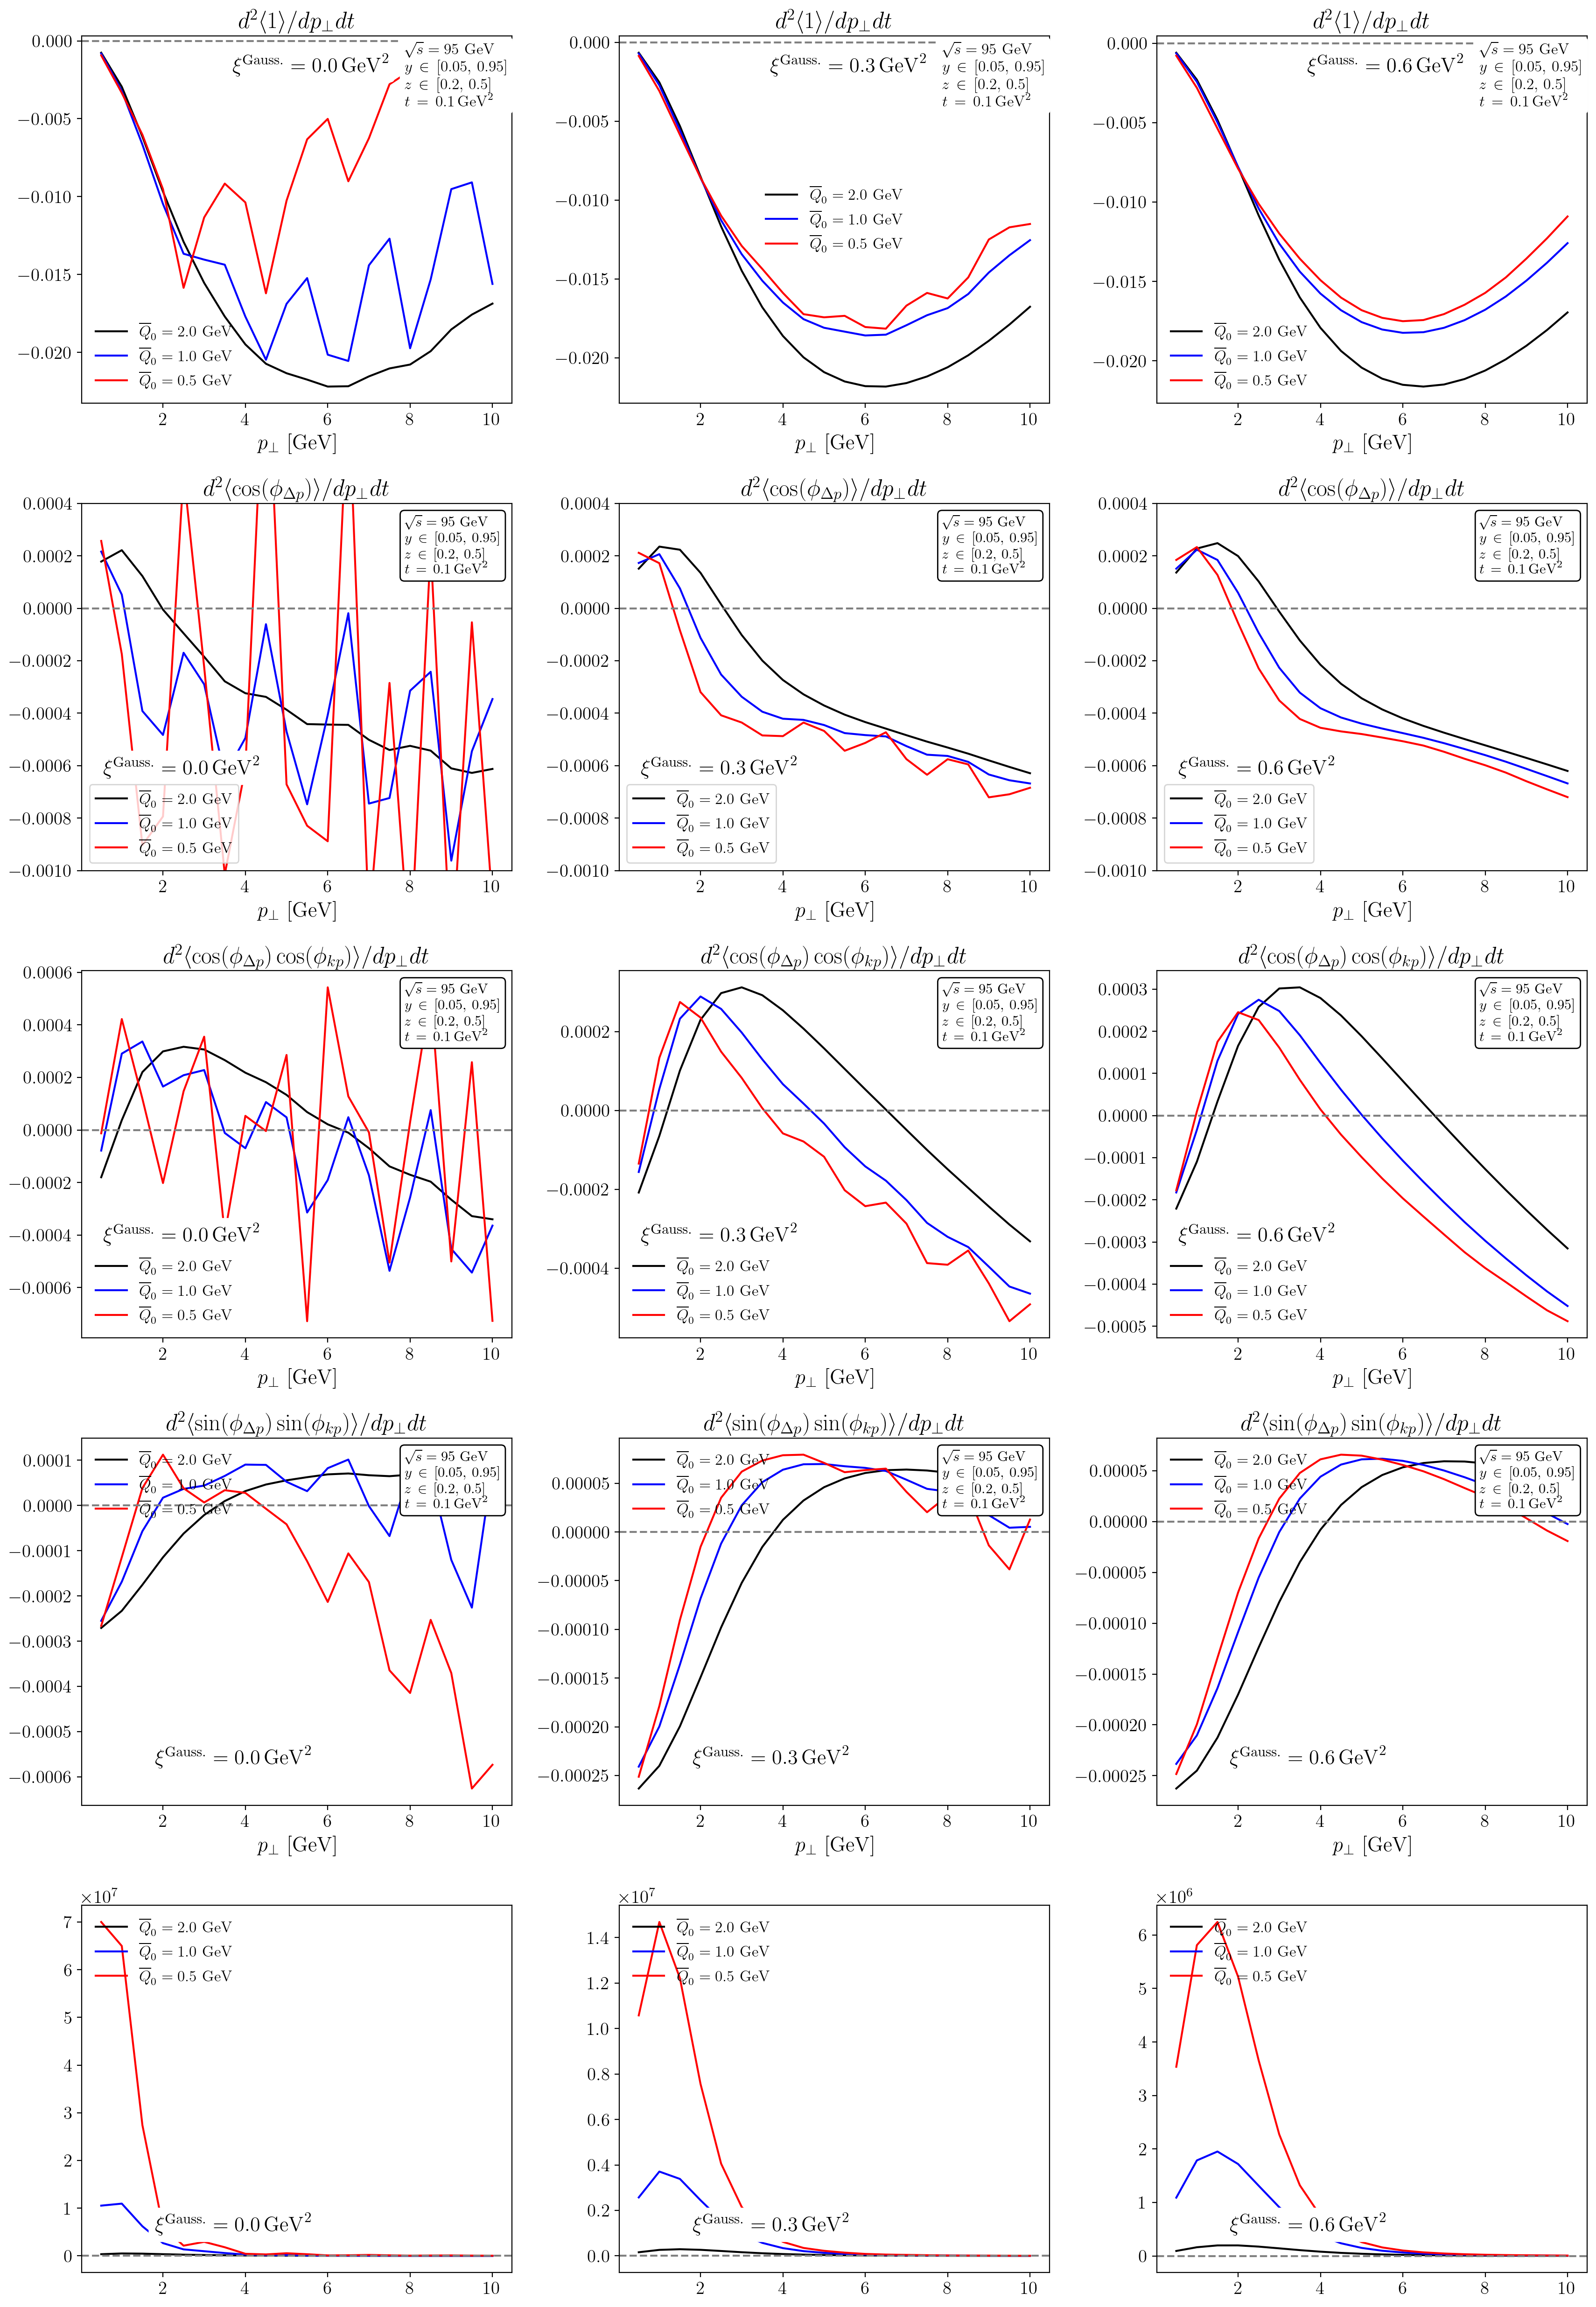

In [17]:
asp_ratio = 3.5/3
psize = 5
nrows, ncols = 5, len(xis)
fig, ax = plt.subplots(nrows, ncols, figsize=(asp_ratio*psize*ncols, psize*nrows))

colors = ['black', 'blue', 'red', 'blue', 'black']
linestyles = ['-', '-', '-', '-', '-']
for ixi, xi in enumerate(xis):
    for ir0, r0 in enumerate(r0s):
        for icorr, corr in enumerate(data[xi][r0]):
            if corr != 'denom':
                ax[icorr, ixi].plot(pT_values, data[xi][r0][corr], label=fr'$\overline{{Q}}_0 = {r0}\,\, \mathrm{{GeV}}$', color=colors[ir0], linestyle=linestyles[ir0])
            else: 
                ax[icorr, ixi].plot(pT_values, data[xi][r0][corr], label=fr'$\overline{{Q}}_0 = {r0}\,\, \mathrm{{GeV}}$', color=colors[ir0], linestyle=linestyles[ir0])
                
for i, xi in enumerate(xis):
    ax[0, i].set_xlabel(r'$p_\perp \,\, [\mathrm{GeV}]$')
    ax[0, i].set_title(r'$ d^2 \langle 1 \rangle / d p_\perp dt$')
    ax[0, i].text(
        0.75, 0.8, info_text, 
        transform=ax[0, i].transAxes,
        ha='left', va='bottom', 
        fontsize=12, wrap=True, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='none')
    )
    ax[0, i].text(
        0.35, 0.89, rf'$\xi^{{\mathrm{{Gauss.}}}}={xi}\, \mathrm{{GeV}}^{{2}}$', 
        transform=ax[0, i].transAxes,
        ha='left', va='bottom', 
        fontsize=16, wrap=True, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='none')
    )
    ax[0, i].legend(frameon=False)
    ax[0, i].axhline(y=0, color='gray', linestyle='--')
    # ax[0, i].set_ylim([0, 12])

    ax[1, i].set_xlabel(r'$p_\perp \,\, [\mathrm{GeV}]$')
    ax[1, i].set_title(r'$ d^2 \langle \cos(\phi_{\Delta p}) \rangle / d p_\perp dt$')
    ax[1, i].text(
        0.75, 0.8, info_text, 
        transform=ax[1, i].transAxes,
        ha='left', va='bottom', 
        fontsize=11, wrap=True, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='black')
    )
    ax[1, i].text(
        0.05, 0.25, rf'$\xi^{{\mathrm{{Gauss.}}}}={xi}\, \mathrm{{GeV}}^{{2}}$', 
        transform=ax[1, i].transAxes,
        ha='left', va='bottom', 
        fontsize=16, wrap=True, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='none')
    )
    ax[1,i].legend(loc='lower left', frameon=True)
    ax[1, i].axhline(y=0, color='gray', linestyle='--')
    ax[1, i].set_ylim([-0.001, 0.0004])

    ax[2, i].set_xlabel(r'$p_\perp \,\, [\mathrm{GeV}]$')
    ax[2, i].set_title(r'$ d^2 \langle \cos(\phi_{\Delta p}) \cos(\phi_{k p}) \rangle / d p_\perp dt$')
    ax[2, i].text(
        0.75, 0.8, info_text, 
        transform=ax[2, i].transAxes,
        ha='left', va='bottom', 
        fontsize=11, wrap=True, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='black')
    )
    ax[2, i].text(
        0.05, 0.25, rf'$\xi^{{\mathrm{{Gauss.}}}}={xi}\, \mathrm{{GeV}}^{{2}}$', 
        transform=ax[2, i].transAxes,
        ha='left', va='bottom', 
        fontsize=16, wrap=True, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='none')
    )
    ax[2,i].legend(frameon=False, loc='lower left')
    ax[2, i].axhline(y=0, color='gray', linestyle='--')
    # ax[2, i].set_ylim([-4, 10])
    
    ax[3, i].set_xlabel(r'$p_\perp \,\, [\mathrm{GeV}]$')
    ax[3, i].set_title(r'$ d^2 \langle \sin(\phi_{\Delta p}) \sin(\phi_{k p}) \rangle / d p_\perp dt$')
    ax[3, i].text(
        0.75, 0.8, info_text, 
        transform=ax[3, i].transAxes,
        ha='left', va='bottom', 
        fontsize=11, wrap=True, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='black')
    )
    ax[3, i].text(
        0.17, 0.1, rf'$\xi^{{\mathrm{{Gauss.}}}}={xi}\, \mathrm{{GeV}}^{{2}}$', 
        transform=ax[3, i].transAxes,
        ha='left', va='bottom', 
        fontsize=16, wrap=True, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='none')
    )
    ax[3,i].legend(frameon=False, loc='upper left')
    ax[3, i].axhline(y=0, color='gray', linestyle='--')
    # ax[3, i].set_ylim([-4, 10])

    ax[4, i].text(
        0.17, 0.1, rf'$\xi^{{\mathrm{{Gauss.}}}}={xi}\, \mathrm{{GeV}}^{{2}}$', 
        transform=ax[4, i].transAxes,
        ha='left', va='bottom', 
        fontsize=16, wrap=True, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='none')
    )
    ax[4, i].legend(frameon=False, loc='upper left')
    ax[4, i].axhline(y=0, color='gray', linestyle='--')
    # ax[4, i].set_ylim([7, 18])

plt.tight_layout()
plt.show()

fig.savefig(f"plots/dsa_IR_reg.pdf", dpi=400, bbox_inches="tight")
